# SrFit example for a simple linear fit to a noisy data.

Simulate linear data with some random Gaussian noise and plot the generated "observed" data (xobs, yobs).

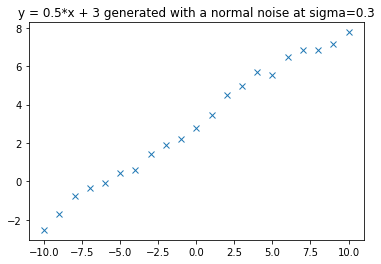

In [1]:
from __future__ import print_function
%matplotlib inline
from matplotlib.pyplot import plot, title

import numpy as np
xobs = np.arange(-10, 10.1)
dyobs = 0.3 * np.ones_like(xobs)
yobs = 0.5 * xobs + 3 + dyobs * np.random.randn(xobs.size)
plot(xobs, yobs, 'x')
title('y = 0.5*x + 3 generated with a normal noise at sigma=0.3');

We are going to define a line fitting regression using SrFit.
At first we create a SrFit Profile object that holds the observed data.

In [2]:
from diffpy.srfit.fitbase import Profile
linedata = Profile()
linedata.setObservedProfile(xobs, yobs, dyobs)

The second step is to create a FitContribution object, which associates observed profile with a mathematical model for the dependent variable.

In [3]:
from diffpy.srfit.fitbase import FitContribution
linefit = FitContribution('linefit')
linefit.setProfile(linedata)
linefit.setEquation("A * x + B")

 SrFit objects can be examined by calling their **show()** function.  SrFit
 parses the model equation and finds two parameters A, B at independent
 variable x.  The values of parameters A, B are at this stage undefined.


In [4]:
linefit.show()

Parameters
------------------------------------------------------------------------------
x   [-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   
y   [-2.52996905 -1.70190978 -0.76241339 -0.34180649 -0.08813641  0.42593539
 
dy  [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 
B   None
A   None


We can set A and B to some specific values and calculate model
observations.  The x and y attributes of the FitContribution are 
the observed values, which may be re-sampled or truncated to a shorter 
fitting range.

In [5]:
linefit.A
linefit.A = 3
linefit.B = 5
print(linefit.A, linefit.A.value)
print(linefit.B, linefit.B.value)

Parameter(A) 3
Parameter(B) 5


`linefit.evaluate()` returns the modeled values and `linefit.residual()`,
the difference between observed and modeled data scaled by estimated
standard deviations.

linefit.evaluate() = [-25. -22. -19. -16. -13. -10.  -7.  -4.  -1.   2.   5.   8.  11.  14.
  17.  20.  23.  26.  29.  32.  35.]
linefit.residual() = [-74.90010316 -67.66030072 -60.79195538 -52.19397837 -43.0395453
 -34.75311795 -25.27353269 -18.0940812   -9.60790418  -0.76985364
   7.45190484  15.21304337  21.64017576  30.13508961  37.63866569
  48.21923579  55.05860898  63.78462426  73.91537137  82.82127424
  90.76017463]


Text(0.5,1,'Line simulated at A=3, B=5')

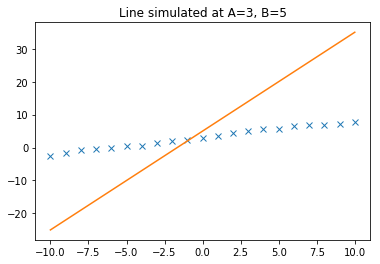

In [6]:
print("linefit.evaluate() =", linefit.evaluate())
print("linefit.residual() =", linefit.residual())
plot(xobs, yobs, 'x', linedata.x, linefit.evaluate(), '-')
title('Line simulated at A=3, B=5')

 We want to find the optimum model parameters that fit the simulated curve
 to the observations.  This is done by associating FitContribution with
 a FitRecipe object.  FitRecipe can manage multiple fit contributions and
 optimize all models to fit their respective profiles.

In [7]:
from diffpy.srfit.fitbase import FitRecipe
rec = FitRecipe()

The `clearFitHooks()` function suppresses printout of iteration numbers.  The `addContribution()` function includes the specified FitContribution in the FitRecipe, which acts as a top-level manager of all associated fits. 

In [8]:
rec.clearFitHooks()
rec.addContribution(linefit)
rec.show()

Parameters
------------------------------------------------------------------------------
linefit.x   [-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2. 
linefit.y   [-2.52996905 -1.70190978 -0.76241339 -0.34180649 -0.08813641  0.42
linefit.dy  [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0
linefit.B   5
linefit.A   3


 FitContributions may have many parameters.  We need to tell the recipe
 which of them should be controlled and potentially optimized in a fit.

In [9]:
rec.addVar(rec.linefit.A)
rec.addVar(rec.linefit.B)

 The call of the addVar function also created two attributes A and B for the rec object,
 which link to the A and B parameters of the linefit contribution.


In [10]:
print("rec.A =", rec.A)
print("rec.A.value =", rec.A.value)

rec.A = ParameterProxy(A)
rec.A.value = 3


 The names of the declared variables are stored in the `rec.names` attribute
 and the corresponding values in `rec.values`.

In [11]:
print("rec.values =", rec.values)
print("rec.names =", rec.names)

rec.values = [3 5]
rec.names = ['A', 'B']


 Finally the recipe objects provides a residual() function to calculate
 the difference between the observed and simulated values.  The residual
 function can accept a list of new variable values in the same order as
 rec.names.

In [12]:
print("rec.residual() =", rec.residual())
print("rec.residual([2, 4]) =", rec.residual([2, 4]))

rec.residual() = [-74.90010316 -67.66030072 -60.79195538 -52.19397837 -43.0395453
 -34.75311795 -25.27353269 -18.0940812   -9.60790418  -0.76985364
   7.45190484  15.21304337  21.64017576  30.13508961  37.63866569
  48.21923579  55.05860898  63.78462426  73.91537137  82.82127424
  90.76017463]
rec.residual([2, 4]) = [-44.90010316 -40.99363406 -37.45862205 -32.19397837 -26.37287864
 -21.41978462 -15.27353269 -11.42741453  -6.27457084  -0.76985364
   4.1185715    8.54637671  11.64017576  16.80175628  20.97199903
  28.21923579  31.72527564  37.11795759  43.91537137  49.48794091
  54.09350796]


The FitRecipe.residual function can be directly used with the scipy
leastsq function for minimizing a sum of squares.

In [13]:
from scipy.optimize import leastsq
leastsq(rec.residual, rec.values)

(array([0.51478759, 3.00637434]), 3)

 Recipe variables and the linked line-function parameters are set to the
 new optimized values.

In [14]:
print(rec.names, "-->", rec.values)
linefit.show()

['A', 'B'] --> [0.51478759 3.00637434]
Parameters
------------------------------------------------------------------------------
x   [-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   
y   [-2.52996905 -1.70190978 -0.76241339 -0.34180649 -0.08813641  0.42593539
 
dy  [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 
B   3.0063743428355783
A   0.514787593824258


 The calculated function is available in the `ycalc` attribute of the profile.
 It can be also accessed from the `linefit` contribution attribute of the
 recipe as `rec.linefit.profile.ycalc`.

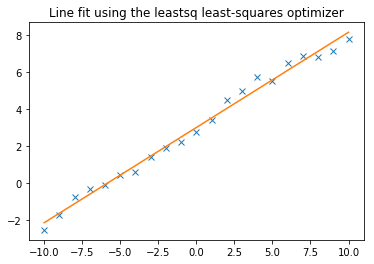

In [15]:
plot(linedata.x, linedata.y, 'x', linedata.x, linedata.ycalc, '-')
title('Line fit using the leastsq least-squares optimizer');

The `FitRecipe.scalarResidual()` function returns the sum of squares and can
be used with a minimizer that requires a scalar function:

Optimization terminated successfully.
         Current function value: 23.478116
         Iterations: 54
         Function evaluations: 103
['A', 'B'] --> [0.514788   3.00642642]


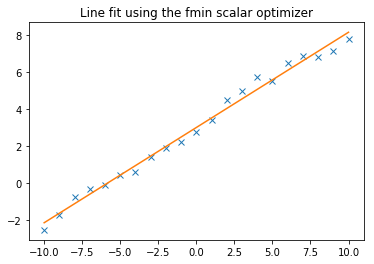

In [16]:
from scipy.optimize import fmin
fmin(rec.scalarResidual, [1, 1])
print(rec.names, "-->", rec.values)
plot(linedata.x, linedata.y, 'x', linedata.x, linedata.ycalc, '-')
title('Line fit using the fmin scalar optimizer');

For a converged fit recipe, the details of the fit can be extracted
 with the FitResults class.

In [17]:
from diffpy.srfit.fitbase import FitResults
res = FitResults(rec)
print(res)

Overall
------------------------------------------------------------------------------
Residual       23.47811597
Contributions  23.47811597
Restraints     0.00000000
Chi2           23.47811597
Reduced Chi2   1.23569031
Rw             0.07305008

Variables
------------------------------------------------------------------------------
A  5.14788001e-01 +/- 1.08112495e-02
B  3.00642642e+00 +/- 6.54653675e-02

Variable Correlations greater than 25%
------------------------------------------------------------------------------
No correlations greater than 25%



Variables defined in the recipe can be fixed to a constant value.

In [18]:
rec.fix(B=0)

The fixed variables can be checked using the "fixednames" and
 "fixedvalues" attributes of a recipe.

In [19]:
print("free:", rec.names, "-->", rec.names)
print("fixed:", rec.fixednames, "-->", rec.fixedvalues)

free: ['A'] --> ['A']
fixed: ['B'] --> [0]


The fit can be rerun with a constant variable B.

Overall
------------------------------------------------------------------------------
Residual       2132.41167745
Contributions  2132.41167745
Restraints     0.00000000
Chi2           2132.41167745
Reduced Chi2   106.62058387
Rw             0.69618492

Variables
------------------------------------------------------------------------------
A  5.14787594e-01 +/- 1.08112496e-02

Fixed Variables
------------------------------------------------------------------------------
B  0.00000000e+00

Variable Correlations greater than 25%
------------------------------------------------------------------------------
No correlations greater than 25%



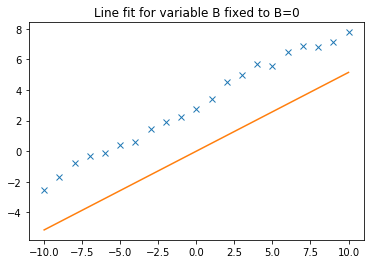

In [20]:
leastsq(rec.residual, rec.values)
print(FitResults(rec))
plot(linedata.x, linedata.y, 'x', linedata.x, linedata.ycalc, '-')
title('Line fit for variable B fixed to B=0');

Fixed variables may be released with the `free()` function.
 Calling it as `free("all")` releases all fixed variables.

In [21]:
rec.free('all')

Variables may be constrained to a result of an expression.

In [22]:
rec.constrain(rec.A, "2 * B")

Perform linear fit where the slope value must be two times the offset.

Overall
------------------------------------------------------------------------------
Residual       1774.81247680
Contributions  1774.81247680
Restraints     0.00000000
Chi2           1774.81247680
Reduced Chi2   88.74062384
Rw             0.63513394

Variables
------------------------------------------------------------------------------
B  2.76009918e-01 +/- 5.38729016e-03

Variable Correlations greater than 25%
------------------------------------------------------------------------------
No correlations greater than 25%



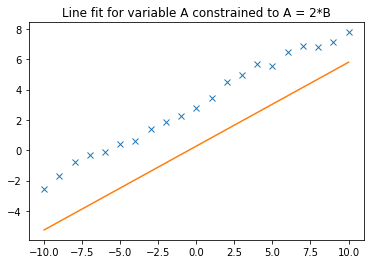

In [23]:
leastsq(rec.residual, rec.values)
print(FitResults(rec))
plot(linedata.x, linedata.y, 'x', linedata.x, linedata.ycalc, '-')
title('Line fit for variable A constrained to A = 2*B');

Constraint expressions can be removed by calling the unconstrain function.

In [24]:
rec.unconstrain(rec.A)

 Variables may be restrained to a specific range.  Here "ub" is the upper
 boundary and "sig" acts as a standard deviation for ((x - ub)/sig)**2
 penalty function.

In [25]:
arst = rec.restrain(rec.A, ub=0.2, sig=0.001)

Perform fit with the line slope restrained to a maximum value of 0.2:

Overall
------------------------------------------------------------------------------
Residual       864.06692821
Contributions  856.93623100
Restraints     7.13069722
Chi2           856.93623100
Reduced Chi2   42.84681155
Rw             0.44132988

Variables
------------------------------------------------------------------------------
A  2.02670337e-01 +/- 9.95749479e-04
B  3.00637434e+00 +/- 6.54653670e-02

Variable Correlations greater than 25%
------------------------------------------------------------------------------
No correlations greater than 25%



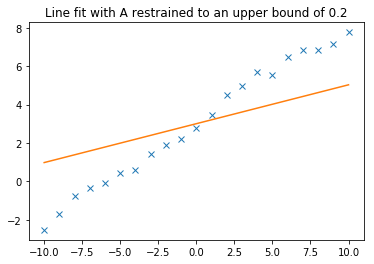

In [26]:
leastsq(rec.residual, rec.values)
print(FitResults(rec))
plot(linedata.x, linedata.y, 'x', linedata.x, linedata.ycalc, '-')
title('Line fit with A restrained to an upper bound of 0.2');